# Data Preparation
### Training a Neural Network to identify the best M3 Combo
By Zach Shelton
5/13/21


In [1]:
#NanoAOD HackSchema
#Solution from Danny Noonan

In [1]:
from __future__ import print_function, division
import uproot
import numpy as np
from coffea.nanoevents import NanoAODSchema,NanoEventsFactory
import coffea
from uproot3_methods import TLorentzVectorArray
import uproot3_methods
import numpy as np
import coffea.hist as hist
import matplotlib.pyplot as plt
import awkward as ak
class HackSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        base_form["contents"].pop("Electron_photonIdx", None)
        super().__init__(base_form)
files ="TTbarPowheg_Semilept_Skim_NanoAOD_1of21.root"
import coffea.processor as processor
from pprint import pprint
file=uproot.open(files)
from pprint import pprint

In [350]:
#Now lets redo with the cuts detailed by CMS Draft Analysis
#https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view
events = NanoEventsFactory.from_root(files,schemaclass=HackSchema,entry_stop=1000).events()

C:\Users\zshel\anaconda3\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
C:\Users\zshel\anaconda3\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
C:\Users\zshel\anaconda3\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
C:\Users\zshel\anaconda3\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
C:\Users\zshel\anaconda3\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
C:\Users\zshel\anaconda3\lib\site-packages\coffea\nanoevents\schemas\nanoaod.py:193: RuntimeWarn

In [351]:
#Condensing_all Lepton_cuts
jets=events.Jet
jetSel = (jets.pt>30) & (abs(jets.eta)<2.4) &(jets.jetId>3)
tightJet = jets[jetSel]
bJet = tightJet[tightJet.btagDeepFlavB > 0.642]
muons = events.Muon
muonSel = (muons.pt>30) & (abs(muons.eta)<2.4)
tightMuon = muons[muonSel]
ele = events.Electron
eleSel = (ele.pt>35)&(abs(ele.eta)<2.4)
tightEle = ele[eleSel]
eventSel = (((ak.num(tightMuon)==1) | (ak.num(tightEle)==1)) &
            (ak.num(tightJet)>= 3) & (ak.num(bJet)>=1)
           )
final = events[eventSel]

In [352]:
#G = Global index of particles - Artifact from Coffea/NanoAOD Tools
print(len(final))

522


In [353]:
events.GenPart.distinctChildren

<GenParticleArray [[[GenParticle, GenParticle, ... []]] type='1000 * var * var *...'>

In [354]:
genPart = events.GenPart
tops = genPart[abs(genPart.pdgId)==6]
tops = tops[tops.hasFlags('isLastCopy')]
tDecay = tops.distinctChildren
tDecay = tDecay[tDecay.hasFlags('isLastCopy')]
t_Events=tDecay[abs(tDecay.pdgId)==5]
W = tDecay[abs(tDecay.pdgId)==24]
W = W[W.hasFlags('isLastCopy')]
WDecay = W.distinctChildren
WDecay = WDecay[WDecay.hasFlags('isLastCopy')]
#t_events is the lone bottom, W_events is the -> two jets
W_Events=ak.flatten(WDecay[ak.all(abs(WDecay.pdgId)<=8,axis=-1)],axis=3)
#select the hadronically decaying W
hadW = ak.num(W_Events,axis=2)==2
#select b quarks associated with hadronically decaying W
hadB = t_Events[hadW]
hadB = ak.flatten(hadB,axis=2)
W_quarks = W_Events[hadW]
W_quarks = ak.flatten(W_quarks,axis=2)
qqb = ak.concatenate([hadB,W_quarks],axis=1)
#To start lets filter for only 1 HadronicW
#Filter out qqb events that have mare than 4 jets
mask=ak.count(qqb.pdgId,axis=1)<4
qqb = qqb[ak.count(qqb.pdgId,axis=1)<4]
print(len(qqb))
print(qqb.pdgId)

1000
[[5, 2, -1], [5, 4, -3], [-5, 1, -2], ... [5, 4, -3], [-5, 3, -4], [5, 2, -1]]


In [357]:
combs=ak.combinations(tightJet,3,replacement=False)
argcombs=ak.argcombinations(tightJet,3,replacement=False)
#In order to accomodate the nearest ccombination specific arrangement, using replacement create EVERY permutation of jets
matchjets=qqb.nearest(tightJet,axis=1)
#byfilling match jets with identical dummyjet, since every combo is unique. it will always be false.
matchjetsfilled=ak.fill_none(ak.pad_none(matchjets,3),dummyjet)

In [358]:
#Finds the arguments of the matching jet in an event
def equal(j1,j2):
    #created this to utilize jit and to avoid any unitended errors, 
    #these are the nearest function values and should be obtainable
    return (j1.pt==j2.pt)&(j1.eta==j2.eta)&(j1.phi==j2.phi)&(j1.mass==j2.mass)&(j1.area==j2.area)
print(equal(events.Jet[0][0],events.Jet[0][0]))

True


In [359]:
#print(combs[0])
@nb.jit(nopython=False)
def test_combo(combination,matchjet):
    h=ak.ArrayBuilder()
    for c in combination:
        #if c is not declared or printed, then it won't compile
        print(c['0'])
        #print(matchjet)
        #Tests if any jets are the same as any matchjets
        #since every combo is unique, there shouldn't be an issue if matchjets are identical nearest.
        test=(equal(c['0'],matchjet[0]))|(equal(c['0'],matchjet[1]))|(equal(c['0'],matchjet[2]))
        test2=((equal(c['1'],matchjet[0]))|(equal(c['1'],matchjet[1]))|(equal(c['1'],matchjet[2])))
        test3=((equal(c['2'],matchjet[0]))|(equal(c['2'],matchjet[1]))|(equal(c['2'],matchjet[2])))
        ftest=test&test2&test3
        h.append(ftest)
    return h
def produce_array(jetcombos,matchjetarray):
    holder=ak.ArrayBuilder()
    for n in range(0,len(matchjetarray)):
        h=test_combo(jetcombos[n],matchjetarray[n])
        holder.append(h)
    return holder
trutharray=ak.flatten(produce_array(combs,matchjetsfilled))

<ipython-input-359-55b5533cc800>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "test_combo" failed type inference due to: Untyped global name 'equal': cannot determine Numba type of <class 'function'>

File "<ipython-input-359-55b5533cc800>", line 10:
def test_combo(combination,matchjet):
    <source elided>
        #print(matchjet)
        test=(equal(c['0'],matchjet[0]))|(equal(c['0'],matchjet[1]))|(equal(c['0'],matchjet[2]))
        ^

  @nb.jit(nopython=False)
<ipython-input-359-55b5533cc800>:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "test_combo" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-359-55b5533cc800>", line 5:
def test_combo(combination,matchjet):
    <source elided>
    h=ak.ArrayBuilder()
    for c in combination:
    ^

  @nb.jit(nopython=False)
C:\Users\zshel\anaconda3\li

Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet


Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet


Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet
Jet


In [127]:
from matplotlib import pyplot as plt 

In [360]:
jetcombos=ak.flatten(combs)
good_vals=jetcombos[trutharray]
bad_vals=jetcombos[np.invert(trutharray)]

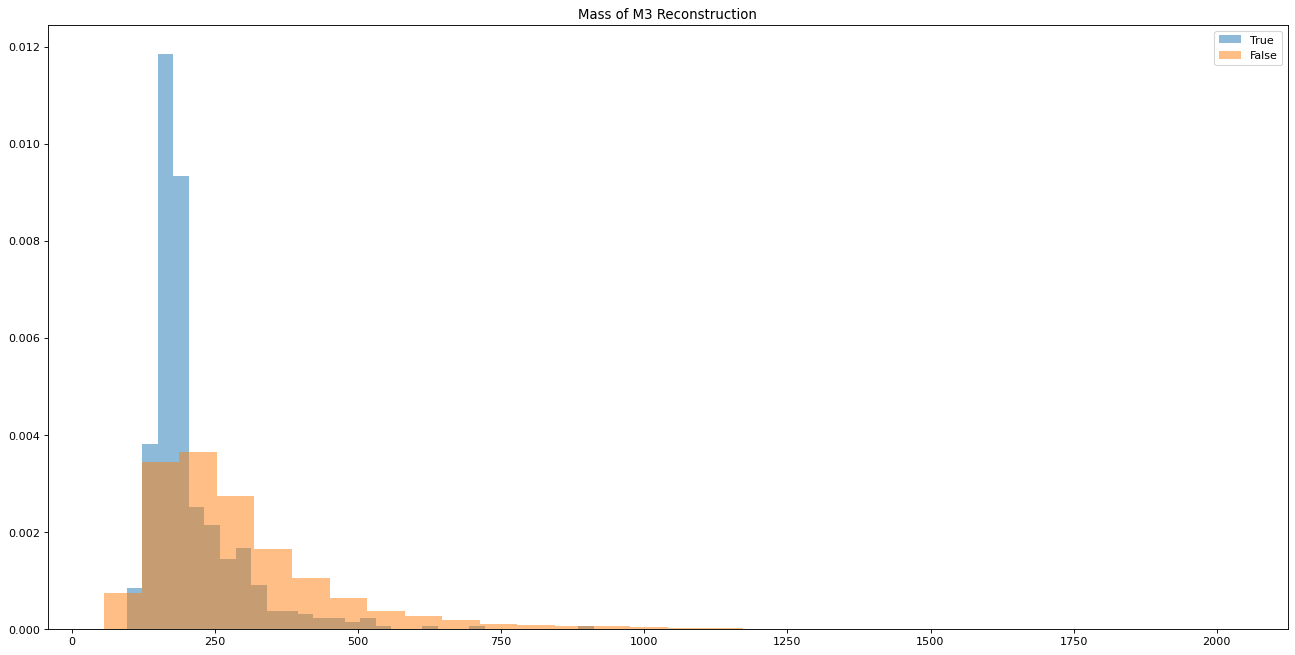

<Figure size 432x288 with 0 Axes>

In [361]:
plt.figure(figsize=(20,10),dpi=80)
greco=good_vals['0']+good_vals['1']+good_vals['2']
breco=bad_vals['0']+bad_vals['1']+bad_vals['2']
plt.hist(greco.mass,bins=30,alpha=.5,density=True)
plt.hist(breco.mass,bins=30,alpha=.5,density=True)
plt.legend(["True","False"])
plt.title("Mass of M3 Reconstruction")
plt.show()
plt.savefig("Mass.png")

In [362]:
jetcombos[0]['0']

Jet

## Dataset Parameters:
* 4-Vector
* Area
* Delta-r 1-2
* Delta-r 2-3
* Delta-r 1-3
* B-tag

In [363]:
j1,j2,j3=ak.unzip(jetcombos)
dR1_2=j1.delta_r(j2)
dR1_3=j1.delta_r(j3)
dR2_3=j2.delta_r(j3)
j1b_tag=j1.btagCSVV2
j2b_tag=j1.btagCSVV2
j3b_tag=j1.btagCSVV2
j1area=j1.area
j2area=j2.area
j3area=j3.area
j1p4=ak.zip({"pt":j1.pt,"phi":j1.phi,"eta":j1.eta,"mass":j1.mass},with_name="PtEtaPhiMLorentzVector")
j2p4=ak.zip({"pt":j2.pt,"phi":j2.phi,"eta":j2.eta,"mass":j2.mass},with_name="PtEtaPhiMLorentzVector")
j3p4=ak.zip({"pt":j3.pt,"phi":j3.phi,"eta":j3.eta,"mass":j2.mass},with_name="PtEtaPhiMLorentzVector")
processedMLdata=ak.zip({"j1p4":j1p4,"j2p4":j2p4,"j3p4":j3p4,
                        "dR12":dR1_2,"dR13":dR1_3,"dR23":dR2_3,
                       "j1btag":j1b_tag,"j2btag":j2b_tag,"j3btag":j3b_tag,
                       "j1area":j1area,"j2area":j2area,"j3area":j3area})

In [364]:
df=ak.to_pandas(processedMLdata)
df.to_csv("data/ML_data.csv",index=False)
vf=ak.to_pandas(trutharray)
vf.to_csv("data/Valid_data.csv",index=False)

In [81]:
import keras
import tensorflow as tf
import pandas as pd

______________________________________________________________________________
# Running Notes and questions
- Losing Data because of arbitrary 8 jet cut?

## Notes for Zach to keep up

create JIT compiler

Seperate values, weights and triggers(X)
read these into tensors for Keras(X)
Best ML Algorithm?
- Deep Neural Net
- Iterative Boosted Tree
    - They are fast
    - External ML algorithm modifies BDT parameters
Should I use Keras or PyTorch

# Sources/Further Reading:

CMS Draft Analysis Note(FIT, AAS, Wayne State, NISTR): https://drive.google.com/file/d/1XEOLyZ-Q1HdEQY379RpyyQkOF1Q8KlsL/view

Invariant Mass Wikipedia Article: https://en.wikipedia.org/wiki/Invariant_mass

Measurement of the semileptonic tt + γ production cross-section in pp collisions at √s = 8 Tev: https://arxiv.org/pdf/1706.08128.pdf

Coffea Documentation: https://coffeateam.github.io/coffea/

Awkward Array Documentation: https://awkward-array.readthedocs.io/en/latest/

AOD DATA GUIDE: https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideAodDataTable